# zaman serilerinin ayrıştırılması

zaman serilerinin ayrıştırılması için iki model tipi vardır: toplamsal ve çarpımsal.

toplamsal modelin özellikleri:

* model kalıbı: $y_{t} = seviye + trend + mevsimsellik + gürültü$
* doğrusal model: zamana göre değişimler tutarlıdır
* doğrusal trend
* aynı sıklık(genişlik) ve salınım(yükseklik) özelliklerine sahip çevrimler.

çarpımsal modelin özellikleri:

* model kalıbı: $y_{t} = seviye * trend * mevsimsellik * gürültü$
* doğrusal olmayan model: zamana göre değişimler tutarsızdır, örneğin üsteldir.
* eğri, doğrusal olmayan trend.
* artan/azalan sıklık ve salınımlı çevrimlere sahip doğrusal olmayan mevsimsellik.

çarpımsal modelle çalışmak istemeyiz. trend/mevsimselliği doğrusallaştırmak için birtakım döüşümler uygulayabiliriz. örneğin serinin logaritmik dönüşümü.

In [171]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose 

In [2]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date = '2000-01-01',
                end_date = '2020-01-31'
               )

In [3]:
df.rename(columns={'Value':'price'}, inplace=True)
df = df.resample('M').last() # veriyi aylık veriye döüştürme ve son değeri alma

hareketli ortalama ve standart sapma:

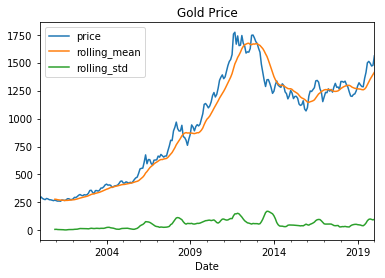

In [6]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

<Figure size 1296x432 with 0 Axes>

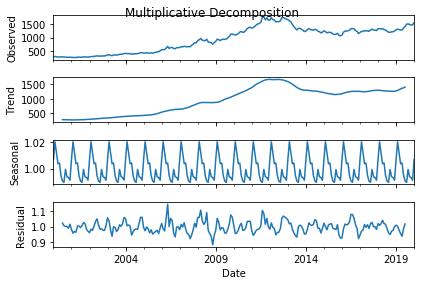

In [11]:
decomposition_results = seasonal_decompose(df.price, model='multiplicative')
plt.figure(figsize=(18, 6))
decomposition_results.plot().suptitle('Multiplicative Decomposition');

ayrıştırma için farklı yöntemler:
* STL decomposition
* SEATS decomposition
* X11 decompostion

# zaman serilerinin facebook prophet ile ayrıştırılması

* genel trend ile birlikte farklı zaman ölçeklerinin(günlük, aylık, yıllık vb) örüntülerinin kombinasyonundan oluşan toplamsal bir modeldir.
* serideki ani değişimleri(tatiller vb) de hesaba katan daha ileri teknikleri de vardır.

In [12]:
from fbprophet import Prophet

In [45]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date = '2000-01-01',
                end_date = '2019-12-31'
               )

In [46]:
#df = df.resample('M').last()
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)

In [47]:
train_indices = df.ds.apply(lambda x: x.year) < 2019
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [59]:
help(model_prophet.add_seasonality)

Help on method add_seasonality in module fbprophet.forecaster:

add_seasonality(name, period, fourier_order, prior_scale=None, mode=None, condition_name=None) method of fbprophet.forecaster.Prophet instance
    Add a seasonal component with specified period, number of Fourier
    components, and prior scale.
    
    Increasing the number of Fourier components allows the seasonality to
    change more quickly (at risk of overfitting). Default values for yearly
    and weekly seasonalities are 10 and 3 respectively.
    
    Increasing prior scale will allow this seasonality component more
    flexibility, decreasing will dampen it. If not provided, will use the
    seasonality_prior_scale provided on Prophet initialization (defaults
    to 10).
    
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used (defaults to additive).
    Additive means the seasonality will be added to the trend,
    multiplicative means it 

In [103]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=12, prior_scale=0.001)
model_prophet.add_seasonality(name='yearly', period=365.5, fourier_order=15, prior_scale=0.001)
model_prophet.fit(df_train)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


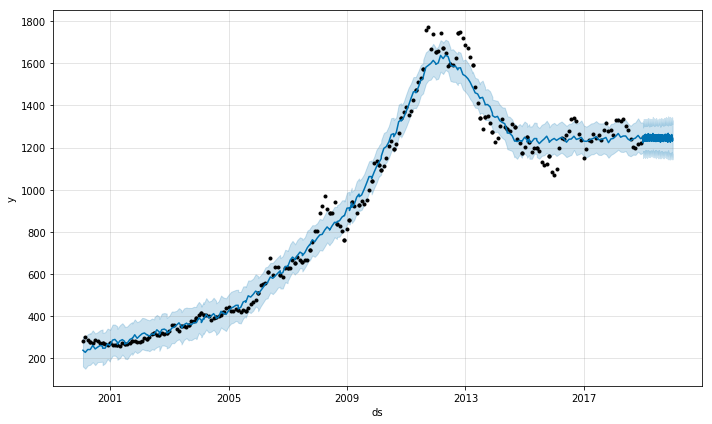

In [104]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred);

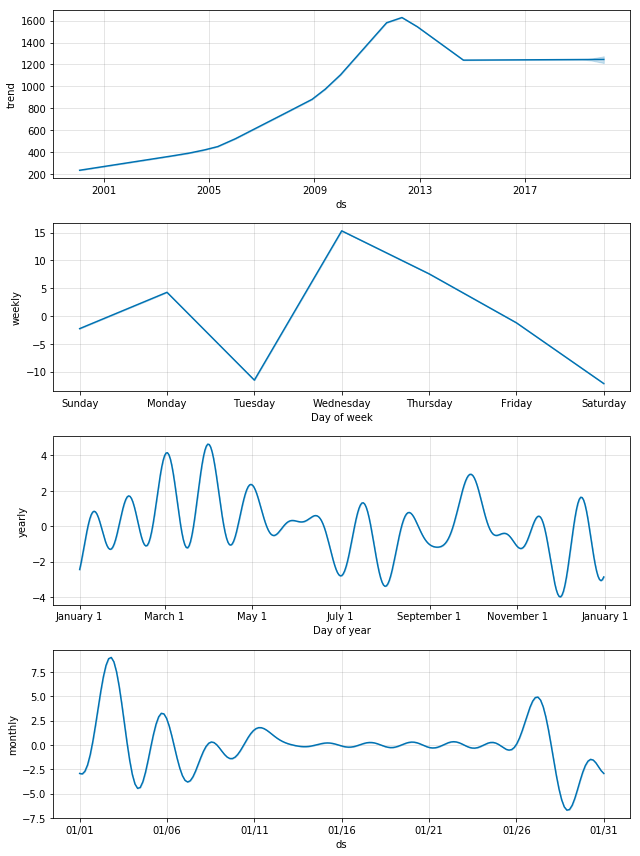

In [105]:
model_prophet.plot_components(df_pred);

In [106]:
df_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
642,2019-12-27,1245.325595,1157.674951,1320.522234,1213.479710,1274.211922,-3.878812,-3.878812,-3.878812,-0.121619,-0.121619,-0.121619,-1.220178,-1.220178,-1.220178,-2.537015,-2.537015,-2.537015,0.0,0.0,0.0,1241.446783
643,2019-12-28,1245.328885,1143.764584,1311.750589,1213.341133,1274.399695,-14.984947,-14.984947,-14.984947,-0.021267,-0.021267,-0.021267,-12.135807,-12.135807,-12.135807,-2.827873,-2.827873,-2.827873,0.0,0.0,0.0,1230.343938
644,2019-12-29,1245.332175,1156.255449,1315.206583,1213.202557,1274.572006,-5.366559,-5.366559,-5.366559,-0.088859,-0.088859,-0.088859,-2.266706,-2.266706,-2.266706,-3.010994,-3.010994,-3.010994,0.0,0.0,0.0,1239.965616
645,2019-12-30,1245.335465,1167.541256,1329.338791,1213.063980,1274.638752,1.509063,1.509063,1.509063,0.328565,0.328565,0.328565,4.259440,4.259440,4.259440,-3.078942,-3.078942,-3.078942,0.0,0.0,0.0,1246.844528
646,2019-12-31,1245.338755,1154.368750,1318.432035,1212.891761,1274.434317,-9.697511,-9.697511,-9.697511,4.851704,4.851704,4.851704,-11.518558,-11.518558,-11.518558,-3.030657,-3.030657,-3.030657,0.0,0.0,0.0,1235.641244


In [107]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

[Text(0, 0.5, 'Gold Price ($)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Gold Price - actual vs. predicted')]

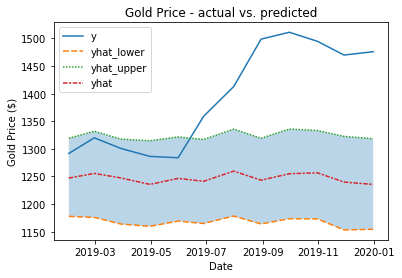

In [108]:
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(df_test.index, 
                df_test.yhat_lower,
                df_test.yhat_upper,
                alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',
       xlabel='Date',
       ylabel='Gold Price ($)')

# zaman serilerinde durağanlık testleri

durağan zaman serisinin, zaman boyunca ortalama, varyansa ve kovaryans gibi istatistiksel özellikleri sabittir. durağanlık, zaman serisi modellemesini ve öngörüsünü daha olanaklı kıldığı için arzu edilen bir özelliktir. 

durağan olmayan zaman serilerinin bazı dezavantajları:

* varyans, model tarafından tanımlanamayabilir.
* kötü model sonuçları.
* veride zamana bağlı anlamlı değişimleri görmek zorlaşır.

bazı durağanlık testleri:

* augmented dickey-fuller (ADF) testi.
* kwiathowski-philips-schmidt-shin (KPSS) testi.
* (kısmi) otokorelasyon fonksiyonunun çizimi (PACF/ACF)

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [131]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [132]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observation Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results

In [134]:
adf_test(df.price)

Test Statistic             3.510499
p-value                    1.000000
# of Lags Used            14.000000
# of Observation Used    129.000000
Critical Value (1%)       -3.482088
Critical Value (5%)       -2.884219
Critical Value (10%)      -2.578864
dtype: float64

In [135]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [136]:
kpss_test(df.price)

C:\Users\Muratoz\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

C:\Users\Muratoz\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Statistic            0.985671
p-value                   0.010000
# of Lags                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

acf/pacf grafikleri:

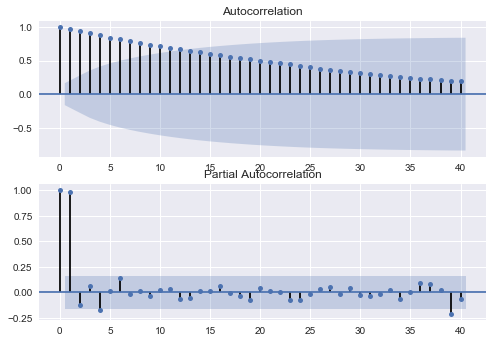

<Figure size 1296x576 with 0 Axes>

In [138]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2,1)
plt.figure(figsize=(18, 8))
plot_acf(df.price, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL);
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL);

# zaman serilerinde durağanlık için düzeltme yapma

durağan olmayan bir seriyi durağanlaştırmak için:

* parasal serilerde enflasyonla düzeltme, tüketici fiyat endeksi(CPI)
* doğal logaritma: üstel trendi doğrusallaştırır
* fark alma

In [150]:
import cpi
from datetime import date
from ch3utils import test_autocorrelation
import numpy as np

In [141]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [143]:
DEFL_DATE = date(2011, 12, 31)

df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price,
                                                      x.dt_index, 
                                                      DEFL_DATE), 
                                axis=1)
#df[['price', 'price_deflated']].plot(title='Gold Price (deflated)')

#plt.tight_layout()
#plt.savefig('images/ch3_im9.png')
#plt.show()

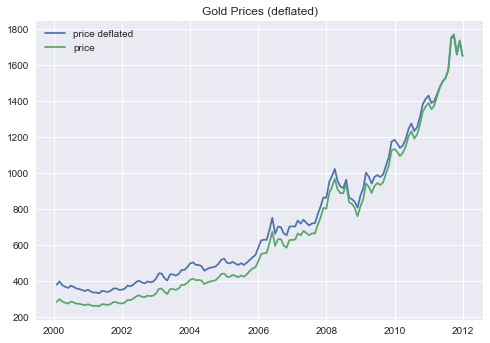

In [147]:
plt.plot(df.dt_index, df.price_deflated, label='price deflated')
plt.plot(df.dt_index, df.price, label='price')
plt.title('Gold Prices (deflated)')
plt.legend()
plt.show()

serileri doğal logaritma kullanarak deflate edip hareketli ortalama metrikleriyle çizdirirsek:

In [152]:
WINDOW = 12

selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(window=WINDOW).mean()
df['rolling_std_log'] = df.price_log.rolling(window=WINDOW).std()

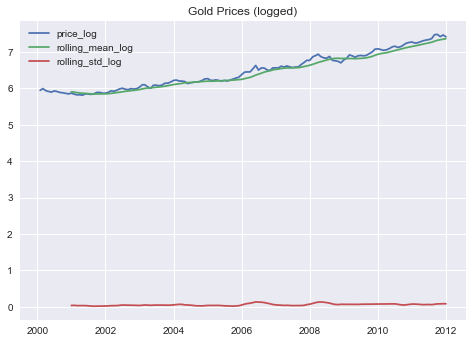

In [153]:
plt.plot(df.dt_index, df.price_log, label='price_log')
plt.plot(df.dt_index, df.rolling_mean_log, label='rolling_mean_log')
plt.plot(df.dt_index, df.rolling_std_log, label='rolling_std_log')
plt.title('Gold Prices (logged)')
plt.legend()
plt.show()

ADF test statistic: 0.89 (p-val: 0.99)
KPSS test statistic: 1.04 (p-val: 0.01)


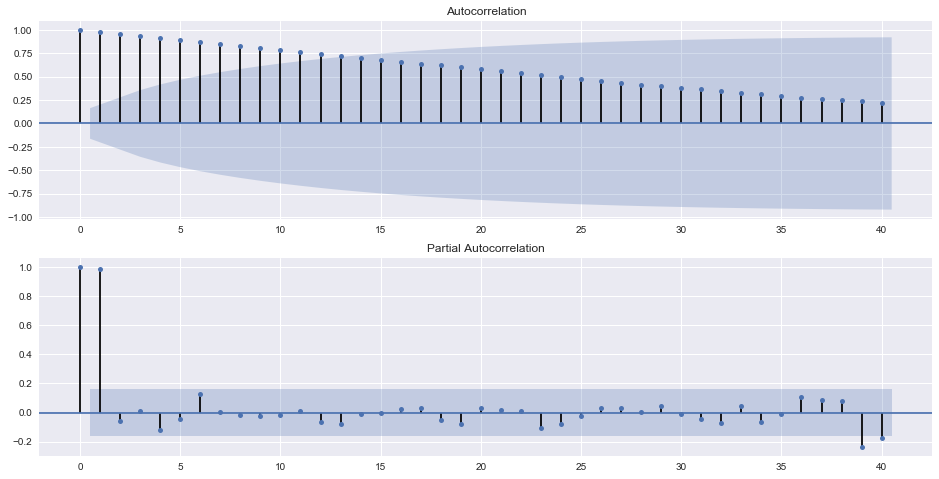

In [155]:
test_autocorrelation(df.price_log);

fark alma:

In [156]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 
                    'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW).mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW).std()

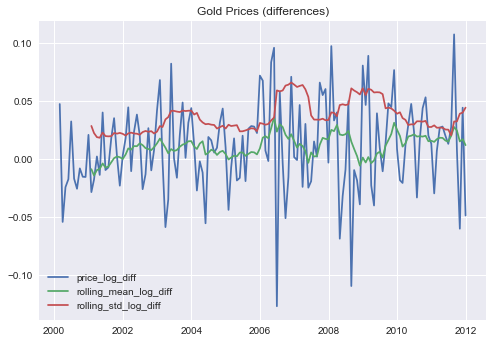

In [158]:
plt.plot(df.dt_index, df.price_log_diff, label='price_log_diff')
plt.plot(df.dt_index, df.roll_mean_log_diff, label='rolling_mean_log_diff')
plt.plot(df.dt_index, df.roll_std_log_diff, label='rolling_std_log_diff')
plt.title('Gold Prices (differences)')
plt.legend()
plt.show()

ADF test statistic: -9.13 (p-val: 0.00)
KPSS test statistic: 0.37 (p-val: 0.09)


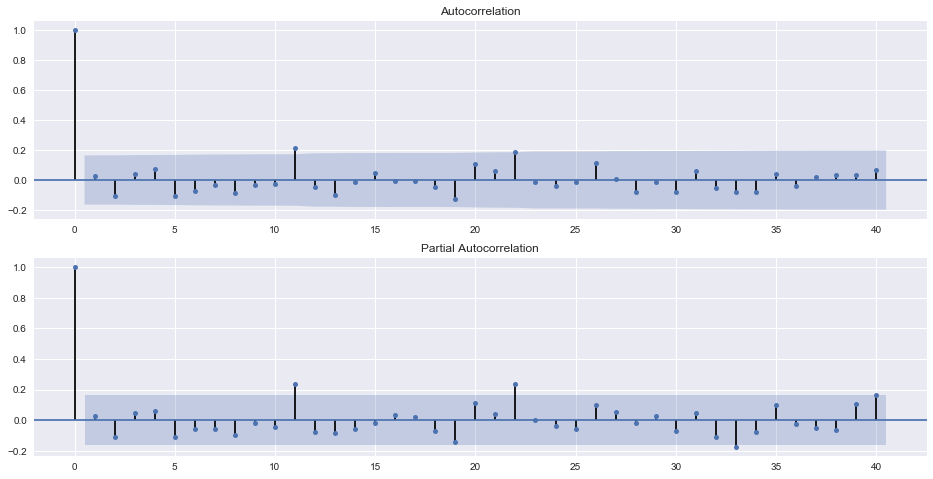

In [160]:
test_autocorrelation(df.price_log_diff.dropna());

`pmdarima` kütüphanesiyle ne kadar fark alınması gerektiği belirlenebilir:

In [161]:
from pmdarima.arima import ndiffs, nsdiffs

In [162]:
print(f"Suggested # of differences (ADF): {ndiffs(df.price, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.price, test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.price, test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 2
Suggested # of differences (PP): 1


aynı kütüphanede mevsimsel farklar için de iki test mevcuttur:
* osborn, chui, smith, and bircenhall(OSCB)
* canova-hansen (CH)

In [163]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df.price, m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df.price, m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


altın fiyatlarında mevsimselliğin olmadığı görülmektedir.

# üstel düzgünleştirme yöntemleriyle zaman serilerinin modellenmesi

üstel düzgünleştirme yöntemleri durağan olmayan veriler(trend ve/veya mevsimsellik olan veriler) için uygundur ve üstel hareketli ortalamalara benzer. öngörüler geçmiş gözlemlerin ağırlıklı ortalamasıdır. bu modeller son gözlemlere daha çok ağırlık verir ve ağırlıklar zamana göre üstel olarak azalır. 

* basit üstel düzgünleştirme (simple exponential smoothing-SES)
* Holt doğrusal trend yöntemi

In [164]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 576x396 with 0 Axes>

In [165]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)

In [196]:
df = yf.download('GOOG',
                 start='2010-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 2264 rows of data.


In [197]:
goog = df.resample('M').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

In [198]:
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

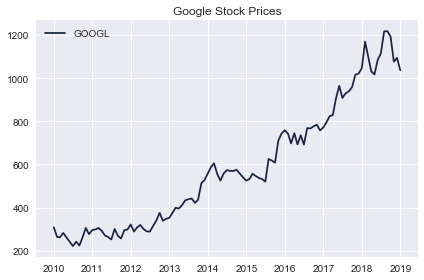

In [199]:
plt.plot(goog.index, goog.values, label='GOOGL')
plt.title('Google Stock Prices')
plt.legend()
plt.tight_layout()
plt.show();

In [200]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

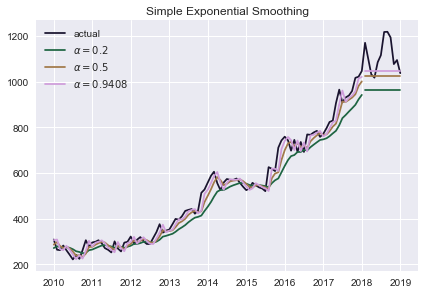

In [201]:
plt.plot(goog.index, goog.values, label='actual', color=COLORS[0])

plt.plot(ses_forecast_1.index, ses_forecast_1.values, label=r'$\alpha=0.2$', color=COLORS[1])
plt.plot(ses_1.fittedvalues.index, ses_1.fittedvalues.values, color=COLORS[1])

plt.plot(ses_forecast_2.index, ses_forecast_2.values, label=r'$\alpha=0.5$', color=COLORS[2])
plt.plot(ses_2.fittedvalues.index, ses_2.fittedvalues.values, color=COLORS[2])

plt.plot(ses_forecast_3.index, ses_forecast_3.values, label=r'$\alpha={0:.4f}$'.format(alpha), color=COLORS[3])
plt.plot(ses_3.fittedvalues.index, ses_3.fittedvalues.values, color=COLORS[3])

plt.tight_layout()
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show();

In [202]:
# Holt's model with linear trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holt's model with exponential trend
hs_2 = Holt(goog_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(goog_train, trend='mul').fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holt's model with exponential trend and damping
hs_3 = Holt(goog_train, exponential=False, 
            damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)

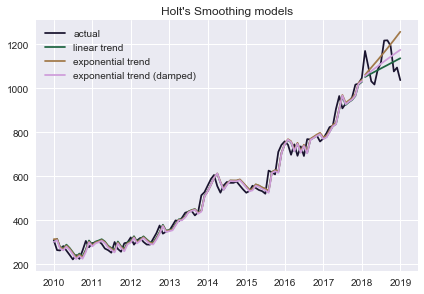

In [203]:
plt.plot(goog.index, goog.values, label='actual', color=COLORS[0])

plt.plot(hs_forecast_1.index, hs_forecast_1.values, label='linear trend', color=COLORS[1])
plt.plot(hs_1.fittedvalues.index, hs_1.fittedvalues.values, color=COLORS[1])

plt.plot(hs_forecast_2.index, hs_forecast_2.values, label='exponential trend', color=COLORS[2])
plt.plot(hs_2.fittedvalues.index, hs_2.fittedvalues.values, color=COLORS[2])

plt.plot(hs_forecast_3.index, hs_forecast_3.values, label=r'exponential trend (damped)'.format(alpha), color=COLORS[3])
plt.plot(hs_3.fittedvalues.index, hs_3.fittedvalues.values, color=COLORS[3])

plt.tight_layout()
plt.title("Holt's Smoothing models")
plt.legend()
plt.show();

In [206]:
SEASONAL_PERIODS = 24

# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)

C:\Users\Muratoz\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



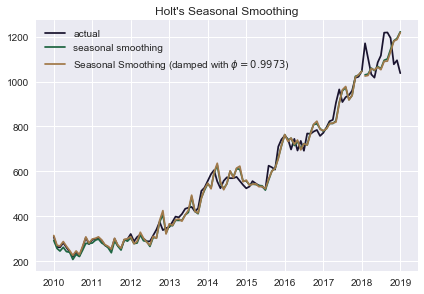

In [207]:
plt.plot(goog.index, goog.values, label='actual', color=COLORS[0])

plt.plot(hw_forecast_1.index, hw_forecast_1.values, label='seasonal smoothing', color=COLORS[1])
plt.plot(hw_1.fittedvalues.index, hw_1.fittedvalues.values, color=COLORS[1])

phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

plt.plot(hw_forecast_2.index, hw_forecast_2.values, label=plot_label, color=COLORS[2])
plt.plot(hw_2.fittedvalues.index, hw_2.fittedvalues.values, color=COLORS[2])

plt.tight_layout()
plt.title("Holt's Seasonal Smoothing")
plt.legend()
plt.show();

# zaman serilerinin ARIMA sınıfı modellerle modellenmesi

In [224]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from ch3utils import test_autocorrelation

In [210]:
df = yf.download('GOOG',
                 start='2015-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=True
                )

[*********************100%***********************]  1 of 1 completed


In [211]:
goog = df.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

In [212]:
goog_diff = goog.diff().dropna()

Text(0.5, 1.0, 'First Differences')

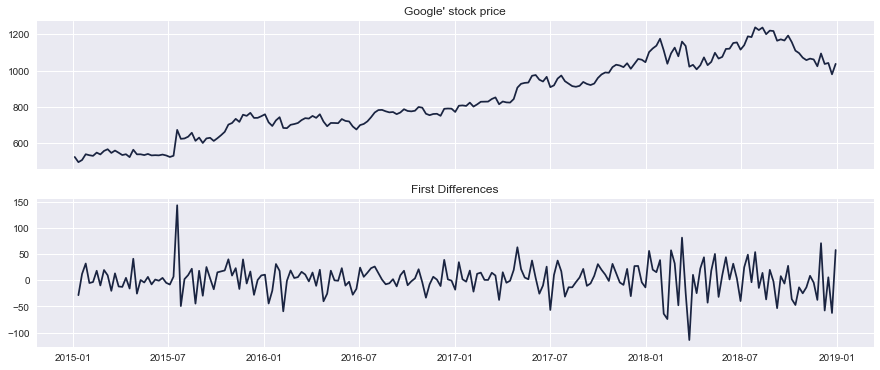

In [218]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,6))
ax[0].plot(goog.index, goog.values, label='GOOG')
ax[0].set_title("Google' stock price")
ax[1].plot(goog_diff.index, goog_diff.values, label='First Differences')
ax[1].set_title("First Differences")

ADF test statistic: -12.79 (p-val: 0.00)
KPSS test statistic: 0.11 (p-val: 0.10)


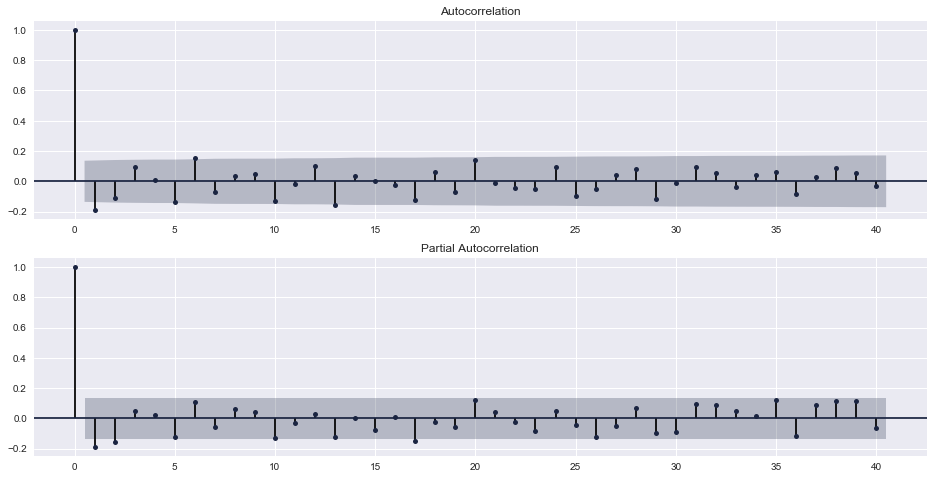

In [220]:
test_autocorrelation(goog_diff);

In [221]:
arima = ARIMA(goog, order=(2,1,1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  208
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -987.233
Method:                       css-mle   S.D. of innovations             27.859
Date:                Tue, 03 Mar 2020   AIC                           1984.466
Time:                        13:44:16   BIC                           2001.154
Sample:                    01-11-2015   HQIC                          1991.214
                         - 12-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4700      1.441      1.714      0.088      -0.354       5.294
ar.L1.D.adj_close    -0.3908      0.280     -1.398      0.164      -0.939       0.157
ar.L2.D.adj_close    -0.1910      0.082     -2.322      0.021      -0.352      -0.030
ma.L1.D.adj_close     0.1780      0.280      0.637      0.525      -0.370       0.726
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0233           -2.0467j            2.2883           -0.3238
AR.2           -1.0233           +2.0467j            2.2883            0.3238
MA.1           -5.6164           +0.0000j            5.6164            0.5000
-----------------------------------------------------------------------------
"""

In [222]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

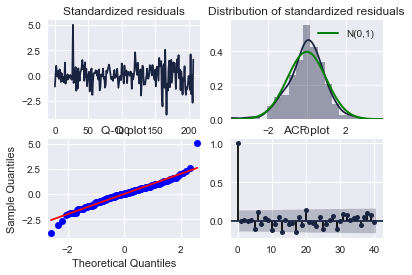

<Figure size 1440x1440 with 0 Axes>

In [227]:
arima_diagnostics(arima.resid, 40)
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.show()

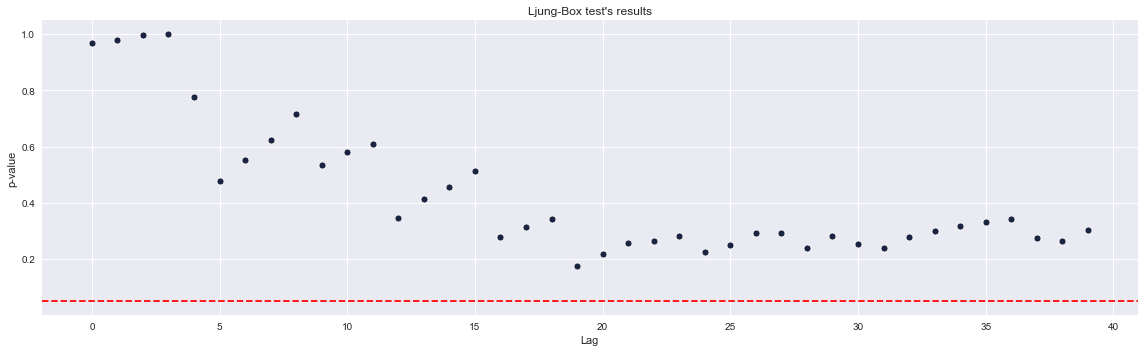

In [228]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
plt.show()

In [229]:
import pmdarima as pm

In [230]:
auto_arima = pm.auto_arima(goog, error_action='ignore', suppress_warnings=True, seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -988.746
Date:                Tue, 03 Mar 2020   AIC                           1983.491
Time:                        13:49:47   BIC                           1993.504
Sample:                             0   HQIC                          1987.540
                                - 209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4607      1.489      1.653      0.098      -0.457       5.379
ma.L1         -0.2376      0.069     -3.421      0.001      -0.374      -0.101
sigma2       786.9631     44.963     17.502      0.000     698.837     875.089
===================================================================================
Ljung-Box (Q):                       48.91   Jarque-Bera (JB):               130.91
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_arima = pm.auto_arima(goog,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False,
                           stepwise=False,
                           approximation=False,
                           n_jobs=-1)
auto_arima.summary()